In [1]:
## personal imports
from processor.processor import Processor as p
from database.market import Market
from database.adatabase import ADatabase
from datetime import datetime
from fund.fund import Fund
from pricer.pricer import Pricer as pricer_list
from ranker.ranker import Ranker as ranker_list
from classifier.classifier import Classifier as classifier_list
from portfolio.aportfolio import APortfolio

from analysis.quarterly_analysis import QuarterlyAnalysis as quarterly_analysis
from analysis.weekly_analysis import WeeklyAnalysis as weekly_analysis

## risk and return class imports
from returns.products import Products as returns_products_class

from fund.fund import Fund
## standard imports
from statistics import variance
import math
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [47]:
backtest_start_date = datetime(2020,1,1)
backtest_end_date  = datetime(2023,1,1)
current_start_date = datetime(2023,1,1)

In [3]:
market = Market()

In [4]:
portfolio = APortfolio(pricer_list.QUARTERLY_STOCK_FINANCIAL
                       ,classifier_list.QUARTERLY_STOCK_FINANCIAL_CLASSIFIER
                       ,ranker_list.QUARTERLY_STOCK_EARNINGS_RANKER)
portfolio_ii = APortfolio(pricer_list.WEEKLY_STOCK_SPECULATION
                          ,classifier_list.WEEKLY_STOCK_SPECULATION_CLASSIFIER
                          ,ranker_list.WEEKLY_STOCK_ROLLING_RANKER)
portfolio_iii = APortfolio(pricer_list.WEEKLY_STOCK_ROLLING
                           ,classifier_list.WEEKLY_STOCK_SPECULATION_CLASSIFIER
                          ,ranker_list.WEEKLY_STOCK_ROLLING_RANKER)
portfolio_iv = APortfolio(pricer_list.WEEKLY_STOCK_WINDOW
                          ,classifier_list.WEEKLY_STOCK_SPECULATION_CLASSIFIER
                          ,ranker_list.WEEKLY_STOCK_ROLLING_RANKER)
portfolios = [portfolio,portfolio_ii,portfolio_iii,portfolio_iv]
fund = Fund(portfolios,backtest_start_date,backtest_end_date,current_start_date)
fund.initialize_portfolios()

In [5]:
market.connect()
sp500 = market.retrieve("sp500")
market.disconnect()
sp500 = sp500.rename(columns={"Symbol":"ticker"})

In [6]:
tyields = returns_products_class.tyields()
bench_returns = returns_products_class.spy_bench()

In [7]:
trades = []
for portfolio in fund.portfolios:
    portfolio.db.connect()
    trade = portfolio.db.retrieve("historical_trades")
    trade["positions"] = portfolio.pricer_class.positions / 2
    trade["portfolio"] = portfolio.name
    trade["pricer_timeframe"] = portfolio.pricer_class.time_horizon_class.naming_convention
    trades.append(trade)
    portfolio.db.disconnect()

In [8]:
t = pd.concat(trades)

In [9]:
t

,year,quarter,ticker,quarterly_delta,quarterly_delta_sign,short_returns,returns,position,actual_returns,value,...,classification,rank,short,market_return,positions,portfolio,pricer_timeframe,week,weekly_delta,weekly_delta_sign
0,2016,1.0,FAST,0.842146,-1.0,0.711797,1.288203,0,0.711797,True,...,True,True,True,1.15,10.0,qsf_qsfc_qser_b_r,quarter,NaN,NaN,NaN
1,2016,2.0,COP,0.447705,-1.0,0.882425,1.117575,0,0.882425,True,...,True,True,True,1.15,10.0,qsf_qsfc_qser_b_r,quarter,NaN,NaN,NaN
2,2016,3.0,IBM,0.186911,-1.0,0.930099,1.069901,0,0.930099,True,...,True,True,True,1.15,10.0,qsf_qsfc_qser_b_r,quarter,NaN,NaN,NaN
3,2016,4.0,CVX,0.242248,1.0,1.160305,1.160305,0,1.160305,True,...,True,True,True,1.15,10.0,qsf_qsfc_qser_b_r,quarter,NaN,NaN,NaN
4,2017,1.0,WMB,0.765865,-1.0,1.049557,0.950443,0,1.049557,True,...,True,True,True,1.15,10.0,qsf_qsfc_qser_b_r,quarter,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289353,2022,NaN,MDT,NaN,NaN,0.992757,0.992757,19,0.992757,False,...,False,False,False,2.00,10.0,wsw_wssc_wsrr_b_r,week,48.0,0.053902,1.0
289354,2022,NaN,TFC,NaN,NaN,1.005624,1.005624,19,1.005624,False,...,False,False,False,2.00,10.0,wsw_wssc_wsrr_b_r,week,49.0,0.100257,1.0
289355,2022,NaN,COST,NaN,NaN,0.976420,0.976420,19,0.976420,False,...,False,False,False,2.00,10.0,wsw_wssc_wsrr_b_r,week,50.0,0.089217,1.0
289356,2022,NaN,VRTX,NaN,NaN,0.990405,0.990405,19,0.990405,False,...,False,False,False,2.00,10.0,wsw_wssc_wsrr_b_r,week,51.0,0.083312,1.0


In [10]:
nonindex_columns = [
"year"
,"quarter"
,"week"
,"ticker"
,"quarterly_delta_sign"
,"quarterly_delta"
,"weekly_delta_sign"
,"weekly_delta"
,"short_returns"
,"returns"
,"floored_returns"
,"actual_returns"
,"position"
,"projected_quarterly_return"
,"positions"] 

In [11]:
indexers = []
indexer = []
for col in t.columns:
    if col not in nonindex_columns:
        indexers.append(list(t[col].unique()))
        indexer.append(col)
stuff = t[indexer].to_dict("records")
parameters = [dict(t) for t in {tuple(d.items()) for d in stuff}]

In [12]:
indexer

['value',
 'ceiling',
 'classification',
 'rank',
 'short',
 'market_return',
 'portfolio',
 'pricer_timeframe']

In [48]:
analysis = []
for parameter in parameters:
    try:
        ledger = t.sort_values(["year",parameter["pricer_timeframe"]]).copy()
        ledger = ledger[ledger["year"]>=backtest_start_date.year]
        for key in parameter.keys():
            ledger = ledger[ledger[key]==parameter[key]]
        positions = int(ledger["positions"].mean())
        anas = weekly_analysis if parameter["pricer_timeframe"] == "week" else quarterly_analysis
        if ledger.index.size > 0:
            cumulative = anas.trade_analysis(indexer,ledger,positions,parameter,tyields,bench_returns)
            analysis.append(cumulative[indexer + ["pv","beta","rrr","sharpe"]].iloc[-1])
    except Exception as e:
        print(str(e))
        continue
a = pd.DataFrame(analysis)

cannot convert float NaN to integer
cannot convert float NaN to integer
cannot convert float NaN to integer
cannot convert float NaN to integer
cannot convert float NaN to integer
cannot convert float NaN to integer


In [49]:
a.sort_values("pv",ascending=False).head(20)

,value,ceiling,classification,rank,short,market_return,portfolio,pricer_timeframe,pv,beta,rrr,sharpe
147,True,False,False,False,False,2.00,wsw_wssc_wsrr_b_r,week,3.259154,0.212773,1.034868,10.613169
147,True,True,False,False,False,2.00,wsw_wssc_wsrr_b_r,week,3.259154,0.212773,1.034868,10.613169
147,True,False,False,False,False,1.15,wsw_wssc_wsrr_b_r,week,3.247826,0.212620,1.034844,10.567522
147,True,True,False,False,False,1.50,wsw_wssc_wsrr_b_r,week,3.247826,0.212620,1.034844,10.567522
147,True,True,False,False,False,1.15,wsw_wssc_wsrr_b_r,week,3.247826,0.212620,1.034844,10.567522
147,True,False,False,False,False,1.50,wsw_wssc_wsrr_b_r,week,3.247826,0.212620,1.034844,10.567522
146,True,False,False,False,False,1.50,wss_wssc_wsrr_b_r,week,3.219771,0.230299,1.037661,9.634459
146,True,True,False,False,False,1.50,wss_wssc_wsrr_b_r,week,3.219771,0.230299,1.037661,9.634459
146,True,True,False,False,False,1.15,wss_wssc_wsrr_b_r,week,3.200063,0.228909,1.037439,9.606903
146,True,False,False,False,False,1.15,wss_wssc_wsrr_b_r,week,3.200063,0.228909,1.037439,9.606903


In [50]:
a.sort_values("pv",ascending=False).groupby("portfolio").nth(0).reset_index()

,portfolio,value,ceiling,classification,rank,short,market_return,pricer_timeframe,pv,beta,rrr,sharpe
0,qsf_qsfc_qser_b_r,False,False,False,False,False,1.15,quarter,1.954199,-0.153513,0.987290,-6.133927
1,wsr_wssc_wsrr_b_r,True,False,False,False,True,1.15,week,2.337116,0.056775,1.010008,23.534284
2,wss_wssc_wsrr_b_r,True,False,False,False,False,1.50,week,3.219771,0.230299,1.037661,9.634459
3,wsw_wssc_wsrr_b_r,True,False,False,False,False,2.00,week,3.259154,0.212773,1.034868,10.613169


In [68]:
top = a.sort_values("pv",ascending=False).iloc[0]
anas = weekly_analysis if top["pricer_timeframe"] == "week" else quarterly_analysis
analysis = t
for key in parameter.keys():
    analysis = analysis[(analysis[key]==top[key])]
naming = top["pricer_timeframe"]
ledger = analysis[["year",naming,"ticker",f"{naming}ly_delta",f"{naming}ly_delta_sign","actual_returns","position"]]
ledger = ledger[ledger["year"]>=backtest_start_date.year]
ledger = ledger.merge(sp500[["ticker","GICS Sector","Security"]],on="ticker",how="left")

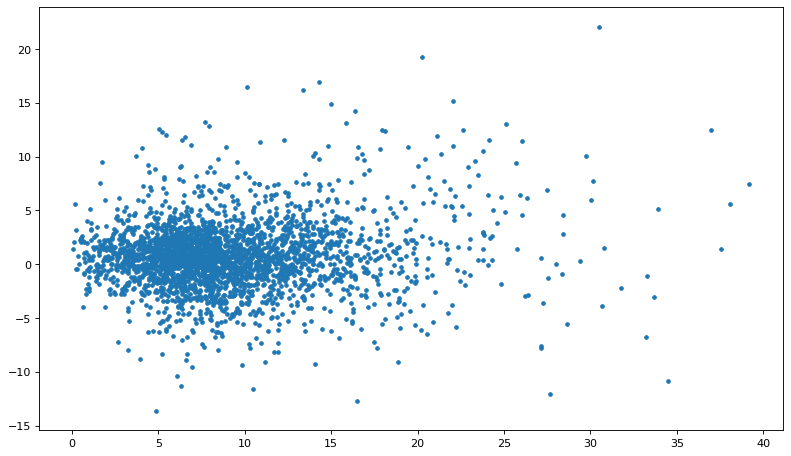

In [69]:
plt.figure(figsize=(12, 7), dpi=80)
plt.scatter(ledger[f"{naming}ly_delta"] * 100, (ledger["actual_returns"]-1)*100,s=10)

In [70]:
ledger.sort_values(["year",naming,"position"],ascending=True).head(20)

,year,week,ticker,weekly_delta,weekly_delta_sign,actual_returns,position,GICS Sector,Security
0,2020,4.0,PAYC,0.105818,1.0,1.041884,0,Information Technology,Paycom
148,2020,4.0,FLT,0.082689,1.0,1.025315,1,Information Technology,Fleetcor
296,2020,4.0,SEDG,0.073095,1.0,1.072416,2,Information Technology,SolarEdge
444,2020,4.0,MSI,0.071552,1.0,1.011629,3,Information Technology,Motorola Solutions
588,2020,4.0,ENPH,0.065443,1.0,1.118197,4,Information Technology,Enphase
732,2020,4.0,INTU,0.063533,1.0,1.010114,5,Information Technology,Intuit
876,2020,4.0,VRSK,0.062402,1.0,1.004636,6,Industrials,Verisk
1020,2020,4.0,CPRT,0.062319,1.0,1.028643,7,Industrials,Copart
1164,2020,4.0,SNPS,0.059607,1.0,1.002926,8,Information Technology,Synopsys
1308,2020,4.0,EFX,0.056961,1.0,0.998040,9,Industrials,Equifax


In [71]:
ledger["actual_returns"].mean()

1.0072339163041253

In [72]:
ledger[ledger["actual_returns"]>1].index.size / ledger.index.size

0.6117564237944386

In [73]:
portfolio = ledger.pivot_table(index=["year",naming],columns="position",values="actual_returns").fillna(1).reset_index()

In [74]:
portfolio

position,year,week,0,1,2,3,4,5,6,7,...,10,11,12,13,14,15,16,17,18,19
0,2020,4.0,1.041884,1.025315,1.072416,1.011629,1.118197,1.010114,1.004636,1.028643,...,1.009606,1.031717,1.004033,0.997683,1.015929,1.014174,1.023223,1.010885,1.048293,1.088814
1,2020,5.0,1.001141,0.985575,0.990529,1.020350,1.010847,1.091581,1.040125,1.015219,...,0.994910,1.013086,0.996425,1.001633,1.013530,1.007880,1.085542,1.016081,1.028026,1.001335
2,2020,6.0,1.077667,1.054336,1.009677,0.976971,1.031180,1.008817,1.013951,1.010642,...,1.016004,1.023680,1.004449,1.000591,0.986831,1.018216,1.029948,1.018639,1.009331,1.024589
3,2020,7.0,1.004209,0.992805,1.012234,1.004770,0.997398,1.005999,0.985013,1.110877,...,1.015719,1.005839,1.021210,0.992883,1.006459,0.994547,1.007606,0.983181,0.975838,1.017485
4,2020,8.0,0.964856,1.038457,0.944552,0.945464,0.963985,0.968797,0.916734,0.911272,...,1.008796,0.970463,0.978027,0.937118,0.937828,0.953507,0.980420,0.937085,0.975026,0.961657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,2022,48.0,0.995868,1.012216,0.981862,1.044122,1.004347,0.999274,0.988058,1.000043,...,1.014802,1.008103,0.988723,0.999168,0.997199,1.015651,0.999112,1.023843,0.992657,1.012656
144,2022,49.0,0.989698,1.002736,0.985359,0.989891,1.016176,1.021315,1.007533,1.029331,...,0.993362,1.045048,0.993173,1.004016,0.981168,1.011418,1.019785,1.007757,1.021833,1.023056
145,2022,50.0,1.008340,0.972365,0.984506,0.988799,0.995501,0.985589,0.999050,0.981259,...,0.970328,0.975812,0.993261,0.944987,0.974177,1.014652,0.989149,0.989299,0.960084,0.973131
146,2022,51.0,0.918000,1.003804,1.015821,0.995214,1.001354,0.996913,1.006368,1.009723,...,0.998687,1.005530,1.010648,1.004069,1.002169,1.008773,1.011363,1.000955,1.012280,1.023595


In [75]:
cumulative = anas.iteration_analysis(portfolio,positions,bench_returns)

In [76]:
cumulative

,0,1,2,3,4,5,6,7,8,9,year,week,pv,adjclose,bench,date_string,date
0,1.041884,1.025315,1.072416,1.011629,1.118197,1.010114,1.004636,1.028643,1.002926,0.998040,2020,4.0,1.031380,329.2920,1.000000,2020-W4,2020-01-24
1,1.043072,1.010525,1.062259,1.032215,1.130326,1.102622,1.044947,1.044298,1.016494,1.018326,2020,5.0,1.050508,330.7825,1.004526,2020-W5,2020-01-31
2,1.124085,1.065433,1.072538,1.008444,1.165570,1.112343,1.059525,1.055412,1.025894,1.022973,2020,6.0,1.071222,325.2840,0.987828,2020-W6,2020-02-07
3,1.128816,1.057767,1.085659,1.013255,1.162537,1.119016,1.043645,1.172432,1.031757,1.038641,2020,7.0,1.085353,330.4440,1.003498,2020-W7,2020-02-14
4,1.089144,1.098446,1.025461,0.957996,1.120669,1.084100,0.956745,1.068405,0.991006,0.968928,2020,8.0,1.036090,336.4040,1.021598,2020-W8,2020-02-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,7.539300,3.887960,0.939968,3.317451,2.867292,2.902632,2.027758,2.324320,4.485501,2.498176,2022,48.0,3.279036,399.8100,1.214150,2022-W48,2022-12-02
144,7.461632,3.898596,0.926205,3.283916,2.913674,2.964501,2.043033,2.392496,4.488569,2.477866,2022,49.0,3.285049,402.6220,1.222690,2022-W49,2022-12-09
145,7.523864,3.790859,0.911855,3.247132,2.900567,2.921781,2.041093,2.347659,4.379583,2.466391,2022,50.0,3.253078,395.2200,1.200211,2022-W50,2022-12-16
146,6.906910,3.805281,0.926282,3.231590,2.904493,2.912760,2.054090,2.370486,4.473363,2.482585,2022,51.0,3.206784,394.6440,1.198462,2022-W51,2022-12-23


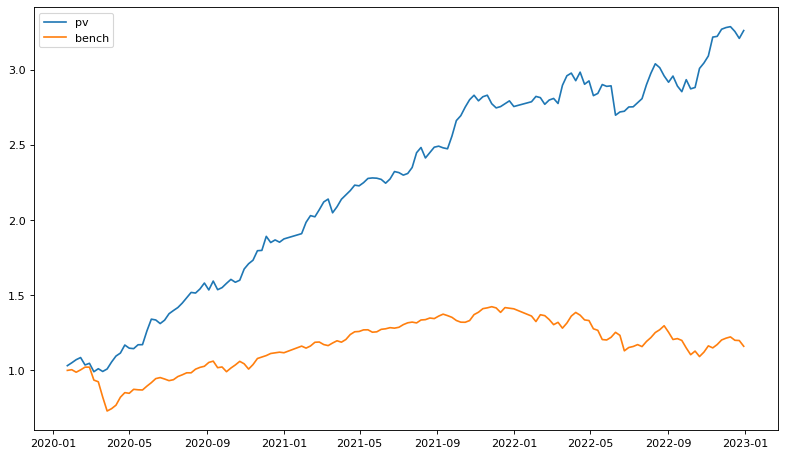

In [77]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(cumulative["date"],cumulative["pv"])
plt.plot(cumulative["date"],cumulative["bench"])
plt.legend(["pv","bench"])

In [78]:
cumulative

,0,1,2,3,4,5,6,7,8,9,year,week,pv,adjclose,bench,date_string,date
0,1.041884,1.025315,1.072416,1.011629,1.118197,1.010114,1.004636,1.028643,1.002926,0.998040,2020,4.0,1.031380,329.2920,1.000000,2020-W4,2020-01-24
1,1.043072,1.010525,1.062259,1.032215,1.130326,1.102622,1.044947,1.044298,1.016494,1.018326,2020,5.0,1.050508,330.7825,1.004526,2020-W5,2020-01-31
2,1.124085,1.065433,1.072538,1.008444,1.165570,1.112343,1.059525,1.055412,1.025894,1.022973,2020,6.0,1.071222,325.2840,0.987828,2020-W6,2020-02-07
3,1.128816,1.057767,1.085659,1.013255,1.162537,1.119016,1.043645,1.172432,1.031757,1.038641,2020,7.0,1.085353,330.4440,1.003498,2020-W7,2020-02-14
4,1.089144,1.098446,1.025461,0.957996,1.120669,1.084100,0.956745,1.068405,0.991006,0.968928,2020,8.0,1.036090,336.4040,1.021598,2020-W8,2020-02-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,7.539300,3.887960,0.939968,3.317451,2.867292,2.902632,2.027758,2.324320,4.485501,2.498176,2022,48.0,3.279036,399.8100,1.214150,2022-W48,2022-12-02
144,7.461632,3.898596,0.926205,3.283916,2.913674,2.964501,2.043033,2.392496,4.488569,2.477866,2022,49.0,3.285049,402.6220,1.222690,2022-W49,2022-12-09
145,7.523864,3.790859,0.911855,3.247132,2.900567,2.921781,2.041093,2.347659,4.379583,2.466391,2022,50.0,3.253078,395.2200,1.200211,2022-W50,2022-12-16
146,6.906910,3.805281,0.926282,3.231590,2.904493,2.912760,2.054090,2.370486,4.473363,2.482585,2022,51.0,3.206784,394.6440,1.198462,2022-W51,2022-12-23


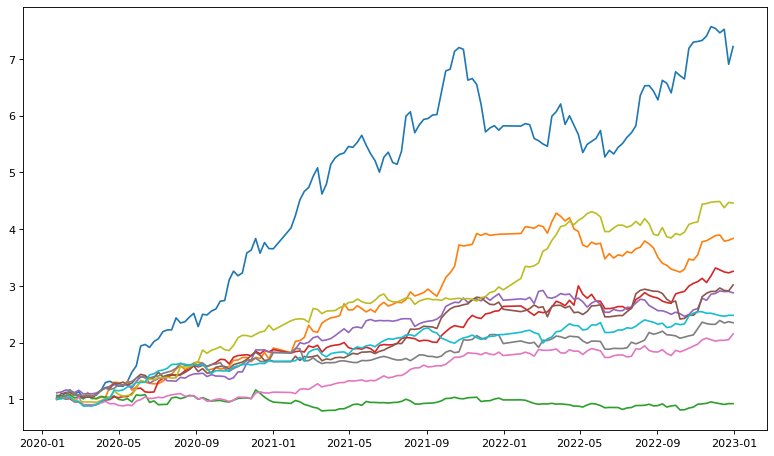

In [79]:
plt.figure(figsize=(12, 7), dpi=80)
position_columns = [x for x in cumulative.columns if x not in ["year","week","quarter","date_string","date","pv","adjclose","bench"]]
for i in position_columns:
    position = cumulative[i]
    plt.plot(cumulative["date"],position)

plt.show()


In [80]:
ledger.groupby(["GICS Sector"]).mean().sort_values("actual_returns",ascending=False)

,year,week,weekly_delta,weekly_delta_sign,actual_returns,position
GICS Sector,,,,,,
Industrials,2020.977358,24.441509,0.095928,1.0,1.010365,9.777358
Consumer Discretionary,2020.876543,32.018519,0.103614,1.0,1.009992,8.469136
Communication Services,2020.901316,25.493421,0.094620,1.0,1.009851,8.960526
Utilities,2021.140187,30.252336,0.068010,1.0,1.007991,11.308411
Health Care,2021.059184,29.426531,0.087224,1.0,1.007243,8.928571
Information Technology,2020.899358,29.959315,0.094209,1.0,1.006582,9.186296
Materials,2021.081081,26.554054,0.091712,1.0,1.005962,9.594595
Consumer Staples,2021.429487,26.660256,0.057670,1.0,1.005593,9.724359
Financials,2020.804878,27.448780,0.085312,1.0,1.005427,11.248780


In [81]:
ledger.groupby(["year",naming,"ticker","Security"]).prod().sort_values("actual_returns",ascending=False).head(30)

weekly_delta  weekly_delta_sign  \
year week ticker Security                                                    
2020 23.0 AAL    American Airlines Group       0.304792                1.0   
     16.0 MRNA   Moderna                       0.202382                1.0   
     17.0 PENN   Penn National Gaming          0.142836                1.0   
     27.0 TSLA   Tesla, Inc.                   0.101568                1.0   
     21.0 BBWI   Bath & Body Works, Inc.       0.133970                1.0   
     49.0 OXY    Occidental Petroleum          0.220646                1.0   
     32.0 PENN   Penn National Gaming          0.149656                1.0   
     17.0 MRO    Marathon Oil                  0.163956                1.0   
     53.0 ALB    Albemarle Corporation         0.077284                1.0   
     43.0 ALGN   Align Technology              0.158653                1.0   
     22.0 UAL    United Airlines Holdings      0.251110                1.0   
2022 17.0 WDC    Western Digital               0.079588                1.0   
          MHK    Mohawk Industries             0.050460                1.0   
2020 21.0 PENN   Penn National Gaming          0.369749                1.0   
     15.0 MRNA   Moderna                       0.179319                1.0   
     23.0 CCL    Carnival                      0.226048                1.0   
     30.0 BBWI   Bath & Body Works, Inc.       0.181054                1.0   
2021 7.0  AAL    American Airlines Group       0.052216                1.0   
2020 37.0 PENN   Penn National Gaming          0.054740                1.0   
     22.0 KIM    Kimco Realty                  0.211413                1.0   
     4.0  ENPH   Enphase                       0.065443                1.0   
     53.0 ENPH   Enphase                       0.122952                1.0   
2021 43.0 UAA    Under Armour (Class A)        0.063650                1.0   
2020 23.0 BA     Boeing                        0.241347                1.0   
2021 30.0 MRNA   Moderna                       0.260183                1.0   
     42.0 TSLA   Tesla, Inc.                   0.108970                1.0   
2020 7.0  DXCM   Dexcom                        0.069188                1.0   
2021 5.0  TWTR   Twitter Inc.                  0.148035                1.0   
2020 22.0 MGM    MGM Resorts                   0.220607                1.0   
     17.0 WYNN   Wynn Resorts                  0.165347                1.0   

                                           actual_returns  position  
year week ticker Security                                            
2020 23.0 AAL    American Airlines Group         1.220762         0  
     16.0 MRNA   Moderna                         1.192656         1  
     17.0 PENN   Penn National Gaming            1.169455        18  
     27.0 TSLA   Tesla, Inc.                     1.164547         3  
     21.0 BBWI   Bath & Body Works, Inc.         1.162184        13  
     49.0 OXY    Occidental Petroleum            1.151261         2  
     32.0 PENN   Penn National Gaming            1.149030         8  
     17.0 MRO    Marathon Oil                    1.142567         9  
     53.0 ALB    Albemarle Corporation           1.131923        11  
     43.0 ALGN   Align Technology                1.131492         0  
     22.0 UAL    United Airlines Holdings        1.130631         2  
2022 17.0 WDC    Western Digital                 1.128036         3  
          MHK    Mohawk Industries               1.125756        17  
2020 21.0 PENN   Penn National Gaming            1.124965         0  
     15.0 MRNA   Moderna                         1.124949         0  
     23.0 CCL    Carnival                        1.124641        13  
     30.0 BBWI   Bath & Body Works, Inc.         1.124219         2  
2021 7.0  AAL    American Airlines Group         1.122850        10  
2020 37.0 PENN   Penn National Gaming            1.119838         8  
     22.0 KIM    Kimco Realty                    1.118792        10  
     4

In [82]:
industry_analysis = ledger.pivot_table(index=["year",naming],columns="GICS Sector",values="actual_returns").fillna(1).reset_index()
industry_analysis[[x for x in industry_analysis.columns if x != "sell_date"]].cumprod()

GICS Sector,year,week,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
0,2020,4.000000e+00,1.014174,1.000000,1.000000,1.000000,1.088814,1.009606,1.010551,1.031028,1.000000,1.000000,1.000000
1,4080400,2.000000e+01,1.025175,1.038578,1.000000,1.000000,1.105452,1.025841,1.014205,1.052640,1.000000,1.000000,1.000000
2,8242408000,1.200000e+02,1.041582,1.084772,1.000000,1.000000,1.115406,1.026448,1.024873,1.076541,1.004564,1.000000,1.000000
3,16649664160000,8.400000e+02,1.041582,1.083153,1.000000,1.000000,1.115653,1.071172,1.026896,1.075939,1.004564,1.015317,1.000000
4,33632321603200000,6.720000e+03,1.041582,1.046754,0.980420,1.000000,1.054641,1.031813,0.970424,1.075939,1.013400,0.961164,0.972744
...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,0,1.981653e+196,1.584498,3.351602,1.282028,1.545163,1.739282,1.788339,2.490842,1.625641,2.012659,1.351433,1.178876
144,0,9.710102e+197,1.602590,3.336847,1.310018,1.545163,1.752384,1.818230,2.490842,1.660291,1.996296,1.351433,1.185816
145,0,4.855051e+199,1.602590,3.248100,1.302059,1.545163,1.719544,1.794965,2.527337,1.608546,1.996296,1.351433,1.180403
146,0,2.476076e+201,1.636906,3.240953,1.304884,1.570904,1.729053,1.788497,2.526431,1.610403,1.996296,1.351433,1.191526
